In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from joblib import dump,load

# 读入数据

In [2]:
# load data
df=pd.read_csv('nCoV_100k_train.labled.csv',encoding='utf-8')
df=df.sample(frac=1.0).reset_index(drop=True)
print(df.columns)
print(df.shape)

Index(['微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片', '微博视频', '情感倾向'], dtype='object')
(100000, 7)


# 数据清洗

In [3]:
# anomaly data
df=df[df['情感倾向'].isin(['0','1','-1'])]
# drop duplicate data
df=df.drop_duplicates(['微博id'])
# reset index
df=df.reset_index(drop=True)
print(df.shape)

(99910, 7)


In [4]:
# convert string to int
map_class={'-1':-1,'0':0,'1':1}
df['情感倾向'] = df['情感倾向'].map(map_class)
print(df.shape)

(99910, 7)


# 准备各数据集

In [5]:
# split train_data, CV_data and test_data
train_per=0.8
CV_per=0.1
train_index=int(df.shape[0]*train_per)
CV_index=int(df.shape[0]*(train_per+CV_per))
train_df=df.iloc[:train_index,:]
CV_df=df.iloc[train_index:CV_index,:]
test_df=df.iloc[CV_index:,:]
print(train_df.shape)
print(CV_df.shape)
print(test_df.shape)

(79928, 7)
(9991, 7)
(9991, 7)


In [6]:
# split features and label
train_X=train_df['微博中文内容']
train_y=train_df['情感倾向']
CV_X=CV_df['微博中文内容']
CV_y=CV_df['情感倾向']
test_X=test_df['微博中文内容']
test_y=test_df['情感倾向']
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(79928,)
(79928,)
(9991,)
(9991,)


# 特征工程

In [7]:
# build count_vect on all weibos
texts_cut=df['微博中文内容'].apply(lambda x:" ".join(jieba.cut(str(x))))
print(texts_cut.shape)
print(texts_cut[0])
# use different n-gram extractors
count_vect_11=CountVectorizer(ngram_range=(1,1),analyzer='word',token_pattern=r'\w{1,}')
count_vect_12=CountVectorizer(ngram_range=(1,2),analyzer='word',token_pattern=r'\w{1,}')
count_vect_22=CountVectorizer(ngram_range=(2,2),analyzer='word',token_pattern=r'\w{1,}')
count_vect_11.fit(texts_cut)
count_vect_12.fit(texts_cut)
count_vect_22.fit(texts_cut)
#X_count=count_vect.fit_transform(texts_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Shazam\AppData\Local\Temp\jieba.cache
Loading model cost 0.808 seconds.
Prefix dict has been built successfully.


(99910,)
[ 推荐 ] 基层 中小学 高级职称 需要 强化 过程 性 评审 。 查看 ? ? ? ? ? ? O 网页 链接 梁好 蒲公英 评论 特约 评论员 日前 ， 山东省 教育厅 、 省人 社厅 联合 印发 《 山东省 基层 中小学 教师 高级职称 评审 条件 指导 标准 》 （ 以下 简称 《 标准 》 ） 明确 ， 在 山东省 基层 中小学 增设 基层 中小学 教师 高级职称 ， 名称 为 基层 中小学 高 ? 展开 全文 c


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
        vocabulary=None)

In [8]:
def textToFeatures(texts,count_vect):
    # word cut
    texts_cut=texts.apply(lambda x:" ".join(jieba.cut(str(x))))
    # vectorize
    texts_count=count_vect.transform(texts_cut)
    return texts_count

In [9]:
train_X_count_11=textToFeatures(train_X,count_vect_11)
train_X_count_12=textToFeatures(train_X,count_vect_12)
train_X_count_22=textToFeatures(train_X,count_vect_22)
CV_X_count_11=textToFeatures(CV_X,count_vect_11)
CV_X_count_12=textToFeatures(CV_X,count_vect_12)
CV_X_count_22=textToFeatures(CV_X,count_vect_22)
#test_X_count=textToFeatures(test_X,count_vect)

In [10]:
print(train_X_count_11.shape)
print(train_X_count_12.shape)
print(train_X_count_22.shape)
print(CV_X_count_11.shape)
print(CV_X_count_12.shape)
print(CV_X_count_22.shape)
#print(test_X_count.shape)

(79928, 149037)
(79928, 1535275)
(79928, 1386238)
(9991, 149037)
(9991, 1535275)
(9991, 1386238)


# 模型搭建

In [11]:
def logisticRegression(X_count,y,max_iter=3000):
    lr=LogisticRegression(max_iter=max_iter)
    lr.fit(X_count,y)
    return lr

# 模型训练

In [12]:
lr_11=logisticRegression(train_X_count_11,train_y.values)
lr_12=logisticRegression(train_X_count_12,train_y.values)
lr_22=logisticRegression(train_X_count_22,train_y.values)

C:\Users\Shazam\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Shazam\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# 验证集预测

In [15]:
lr_11_predict=lr_11.predict(CV_X_count_11)
acc_lr_11=precision_score(y_true=CV_y,y_pred=lr_11_predict,average='micro')
print(acc_lr_11)

0.7147432689420479


In [16]:
lr_12_predict=lr_12.predict(CV_X_count_12)
acc_lr_12=precision_score(y_true=CV_y,y_pred=lr_12_predict,average='micro')
print(acc_lr_12)

0.7337603843459113


In [17]:
lr_22_predict=lr_22.predict(CV_X_count_22)
acc_lr_22=precision_score(y_true=CV_y,y_pred=lr_22_predict,average='micro')
print(acc_lr_22)

0.7154438995095586


In [18]:
best_model=lr_12
best_count_vect=count_vect_12

In [19]:
# save the models
dump(lr_11,'lr_11.joblib')
dump(lr_12,'lr_12.joblib')
dump(lr_22,'lr_22.joblib')
# save the count vectorizors
dump(count_vect_11,'count_vect_11.joblib')
dump(count_vect_12,'count_vect_12.joblib')
dump(count_vect_22,'count_vect_22.joblib')

['count_vect_22.joblib']

In [20]:
# test load count vectorizor
count_vect_test=load('count_vect_12.joblib')
print(count_vect_test)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
        vocabulary=None)


# 测试集测试

In [22]:
test_X_count_12=textToFeatures(test_X,count_vect_test)
print(test_X_count_12.shape)

(9991, 1535275)


In [23]:
# predict class
test_pred=best_model.predict(test_X_count_12)
acc_best_model=precision_score(y_true=test_y,y_pred=test_pred,average='micro')
print(acc_best_model)

0.7357621859673706


In [25]:
pred_num=[np.sum(test_pred==-1),np.sum(test_pred==0),np.sum(test_pred==1)]
true_num=test_y.value_counts().sort_index()
print(pred_num)
print(true_num.values)

[1347, 6297, 2347]
[1659 5678 2654]


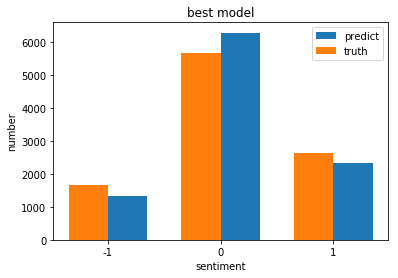

In [26]:
width=0.35
x_position=[width,1+width,2+width]
plt.bar(["-1","0","1"],pred_num,width=width,align='edge',label="predict")
plt.bar([0,1,2],true_num,width=-width,align='edge',label="truth")
plt.legend()
plt.title('best model')
plt.xlabel('sentiment')
plt.ylabel('number')
plt.show()

# 预测概率

In [39]:
# reread file
all_df=pd.read_csv('nCoV_100k_train.labled.csv',encoding='utf-8')
print(df.columns)
print(df.shape)

Index(['微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片', '微博视频', '情感倾向'], dtype='object')
(100000, 7)


In [40]:
# predict class probability on all weibos
all_X_count_12=textToFeatures(all_df['微博中文内容'],count_vect_test)
lr_predict_prob=lr_12.predict_proba(all_X_count_12)
print(lr_predict_prob.shape)

(100000, 3)


In [41]:
out_df=pd.DataFrame(data=lr_predict_prob,columns=['-1','0','1'])
out_df=pd.concat([all_df,out_df],axis=1)
print(out_df.shape)
print(out_df.columns)

(100000, 10)
Index(['微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片', '微博视频', '情感倾向', '-1', '0',
       '1'],
      dtype='object')


In [31]:
#np.savetxt('coarse_label_prob_100k.csv',lr_predict_prob,delimiter=',')

In [42]:
out_df.to_csv('coarse_label_prob_100k.csv')